# Spectral Methods in TensorFlow
Converting some of the examples from [Spectral Methods in MATLAB](https://people.maths.ox.ac.uk/trefethen/spectral.html) by Nick Trefethen into TensorFlow.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

Program 1

```
% p1.m - convergence of fourth-order finite differences

% For various N, set up grid in [-pi,pi] and function u(x):
  Nvec = 2.^(3:12);
  clf, subplot('position',[.1 .4 .8 .5])
  for N = Nvec
    h = 2*pi/N; x = -pi + (1:N)'*h;
    u = exp(sin(x)); uprime = cos(x).*u;

    % Construct sparse fourth-order differentiation matrix:
    e = ones(N,1);
    D =   sparse(1:N,[2:N 1],2*e/3,N,N)...
        - sparse(1:N,[3:N 1 2],e/12,N,N);
    D = (D-D')/h;

    % Plot max(abs(D*u-uprime)):
    error = norm(D*u-uprime,inf);
    loglog(N,error,'.','markersize',15), hold on
  end
  grid on, xlabel N, ylabel error
  title('Convergence of fourth-order finite differences')
  semilogy(Nvec,Nvec.^(-4),'--') 
  text(105,5e-8,'N^{-4}','fontsize',18)

```

In [5]:
def calc_diff_err_p1(n):
    h = 2.*np.pi/n
    x = tf.range(1., n+1.)[:, None]*h - np.pi
    u = tf.exp(tf.sin(x))
    u_prime = tf.cos(x) * u
    e = tf.cast(tf.ones(tf.cast(n, tf.int64)), n.dtype)

    indices = tf.cast(tf.concat([
        tf.tile(tf.range(n)[:, None], [4,1]), 
        tf.concat([tf.roll(tf.range(n)[:, None], i, 0) for i in [-1, -2, 1, 2]], axis=0)
    ],
        axis=1
    ), tf.int64)
    values = tf.concat(
        [2.*e/3., -e/12., -2.*e/3, e/12.], axis=0
    )/h

    D = tf.sparse.reorder(tf.sparse.SparseTensor(indices, values, tf.cast((n, n), tf.int64)))

    err = tf.norm(tf.sparse.sparse_dense_matmul(D, u) - u_prime, np.inf)
    return err

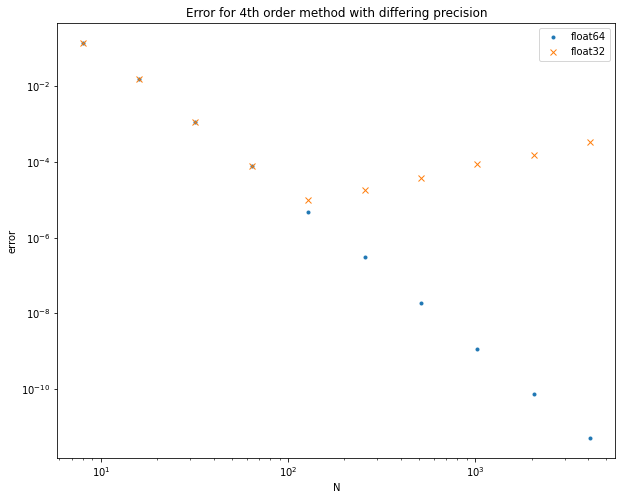

In [4]:
n_vec = 2.**tf.range(3., 13.)


fig = plt.figure(figsize=(10,8))
_ = plt.loglog(n_vec, tf.map_fn(calc_diff_err_p1, tf.cast(n_vec, tf.float64)), 
               linestyle='none', marker='.', label='float64')
_ = plt.loglog(n_vec, tf.map_fn(calc_diff_err_p1, tf.cast(n_vec, tf.float32)), 
               linestyle='none', marker='x', label='float32')
_ = plt.title('Error for 4th order method with differing precision')
_ = plt.xlabel('N')
_ = plt.ylabel('error')
_ = plt.legend()

Program 2
```
% p2.m - convergence of periodic spectral method (compare p1.m)

% For various N (even), set up grid as before:
  clf, subplot('position',[.1 .4 .8 .5])
  for N = 2:2:100;
    h = 2*pi/N;
    x = -pi + (1:N)'*h;
    u = exp(sin(x)); uprime = cos(x).*u;

    % Construct spectral differentiation matrix:
    column = [0 .5*(-1).^(1:N-1).*cot((1:N-1)*h/2)];
    D = toeplitz(column,column([1 N:-1:2]));

    % Plot max(abs(D*u-uprime)):
    error = norm(D*u-uprime,inf);
    loglog(N,error,'.','markersize',15), hold on
  end
  grid on, xlabel N, ylabel error
  title('Convergence of spectral differentiation')
  ```

In [55]:
def calc_diff_err_p2(n):
#     n = n_vec[0]
    h = 2.*np.pi/n
    x = tf.range(1., n+1.)[:, None]*h - np.pi
    u = tf.exp(tf.sin(x))
    u_prime = tf.cos(x) * u
    e = tf.cast(tf.ones(tf.cast(n, tf.int64)), n.dtype)

    d = 0.5*(-1.**np.arange(1., n))/np.tan(np.arange(1., n)*h/2.)
    column = tf.cast(tf.constant([0.] + d.tolist()), n.dtype)
    row = tf.cast(tf.constant([1.] + column.numpy()[-1:0:-1].tolist()), n.dtype)

    D = tf.cast(tf.linalg.LinearOperatorToeplitz(column, row).to_dense(), n.dtype)

    err = tf.norm(D @ u - u_prime, np.inf)
    return err

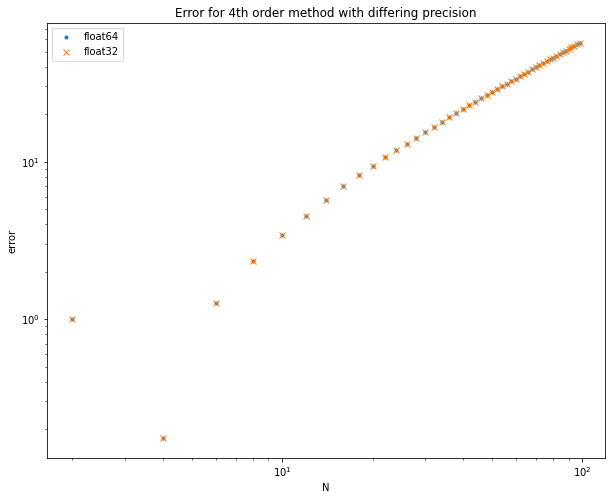

In [56]:
n_vec = tf.range(2., 100., 2.)


fig = plt.figure(figsize=(10,8))
_ = plt.loglog(n_vec, tf.map_fn(calc_diff_err_p2, tf.cast(n_vec, tf.float64)), 
               linestyle='none', marker='.', label='float64')
_ = plt.loglog(n_vec, tf.map_fn(calc_diff_err_p2, tf.cast(n_vec, tf.float32)), 
               linestyle='none', marker='x', label='float32')
_ = plt.title('Error for 4th order method with differing precision')
_ = plt.xlabel('N')
_ = plt.ylabel('error')
_ = plt.legend()

In [24]:
column.numpy()

array([ 0.        , -0.18709834, -0.33288687, -0.433492  , -0.5019424 ,
       -0.5498699 , -0.58471143, -0.610948  ], dtype=float32)